In [57]:
import numpy as np
from sklearn.base import BaseEstimator
from scipy.stats import bernoulli
from collections import Counter

Consider a `SporadicClassifier` that returns a random label in {`True`, `False`} for any test input that’s fed to it. This classifier does not require any training! Hope, that was already obvious to you. Implement this `SporadicClassifier` as a Python class by extending the `BaseEstimator` class of sklearn, so that you have mandatory methods such as `fit(X, y)` and `predict(X)` are implemented. As your guess, the `fit()` method would be a dummy ‘pass’, but the `predict()` method would return `True` or `False` randomly.

In [58]:
class SporadicClassifier(BaseEstimator):
    def __init__(self, p=0.5, method='uniform_random'):
        self.p = 0.5 if p < 0.0 or p > 1.0 else p
        self.method = method if method in ["uniform_random", "bernoulli", "normal"] else "uniform_random"
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # we center the normal distribution at 0.5 instead of 0.0
        if self.method == "gaussian":
            return (0.5 + np.random.randn(len(X))) < self.p
        elif self.method == "bernoulli":
            return np.bool_(bernoulli.rvs(self.p, size=len(X)))
        else:
            return np.random.rand(len(X)) < self.p

__it does not matter what the dataset is, as the classifier is not depending on the inputs__

In [59]:
# let's create a dataset of size 100 instances.
X = np.random.rand(100)

__let's compute the label distribution for different configuration of the classifier__

In [60]:
cla = SporadicClassifier(p=0.3, method='gaussian')
y = cla.predict(X)
c = Counter(y)
{i[0]: i[1] / len(y) for i in c.items()}

{False: 0.67, True: 0.33}

## Task 1

__create reusable functions__

In [61]:
def compute_prior(y):
    # initialize the counter object on the 'y' labels
    c = Counter(y)
    # convert the labels into class proportions
    
    props = {i[0]:i[1]/len(y) for i in c.items()}
    if True not in props:
        props[True] = 0.0
    if False not in props:
        props[False] = 0.0
    return props

__extract the probability of True predictions for the dataset using different random generators__

In [62]:
p_vals = np.arange(0., 1., 0.1)
b_vals = []
g_vals = []
u_vals = []
for p in p_vals:
    cla = SporadicClassifier(p=p, method='bernoulli')
    y = cla.predict(X)
    props = compute_prior(y)
    b_vals.append(props[True])
    
    y = SporadicClassifier(p=p, method='gaussian').predict(X)
    g_vals.append(compute_prior(y)[True])

    y = SporadicClassifier(p=p, method='uniform_random').predict(X)
    u_vals.append(compute_prior(y)[True])

__plot the trends side on the same plot for comparison__

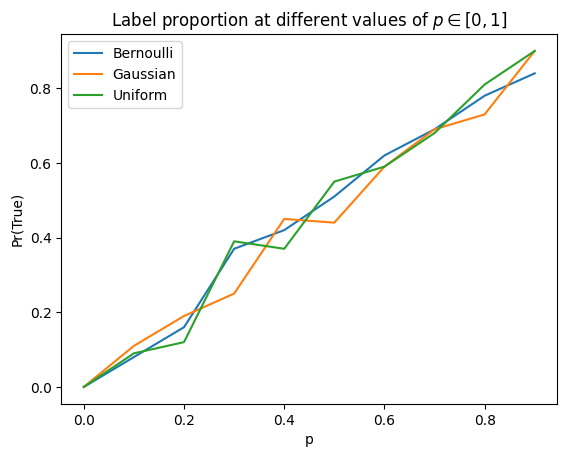

In [63]:
import matplotlib.pyplot as plt
plt.plot(p_vals, b_vals)
plt.plot(p_vals, g_vals)
plt.plot(p_vals, u_vals)
plt.xlabel('p')
plt.ylabel('Pr(True)')
plt.title('Label proportion at different values of $p\in[0,1]$')
plt.legend(['Bernoulli','Gaussian','Uniform'], loc='upper left')
plt.show()

__if the number of samples is increased, the plots tend to understandably become a straight line__

## Task 2

In [64]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

Counter(df['target'].values)

Counter({0: 50, 1: 50, 2: 50})

In [65]:
# set the setosa (class 0) as true and rest as false
df['binary_target'] = df['target'].apply(lambda x: 1 if x == 0 else 0)
X = iris.data
y = df['binary_target'].values

In [66]:
label_prior = compute_prior(y)
print(f"Label prior (proportion of Setosa): {label_prior}")

Label prior (proportion of Setosa): {1: 0.3333333333333333, 0: 0.6666666666666666}


In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

# Prepare variables for storing evaluation metrics
p_values = np.arange(0, 1.1, 0.1)
precision = []
recalls = []
f1_scr = []
tprs = []
fprs = []
auc_list = []
auprc_list = []

# Evaluate Precision, Recall, and F1 at different p-values
for p in p_values:
    classifier = SporadicClassifier(p=p, method='bernoulli')
    y_pred = classifier.predict(X)
    
    # Compute precision, recall, and f1 score
    pre = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    # Append them to list
    precision.append(pre)
    recalls.append(rec)
    f1_scr.append(f1)
    
    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr[1])
    fprs.append(fpr[1])
    auc_list.append(roc_auc)
    
    # Compute Precision-Recall Curve and Area Under the Precision-Recall Curve (AUPRC)
    precision_vals, recall_vals, _ = precision_recall_curve(y, y_pred)
    auprc = auc(recall_vals, precision_vals)
    auprc_list.append(auprc)

c:\Users\Nikshay Jain\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


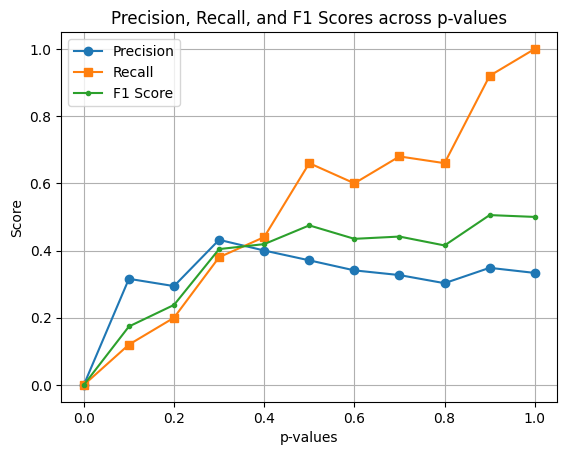

In [68]:
# Plot Precision, Recall, and F1 scores as line plots
plt.plot(p_values, precision, label='Precision', marker='o')
plt.plot(p_values, recalls, label='Recall', marker='s')
plt.plot(p_values, f1_scr, label='F1 Score', marker='.')
plt.xlabel('p-values')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Scores across p-values')
plt.grid(True)
plt.legend()
plt.show()

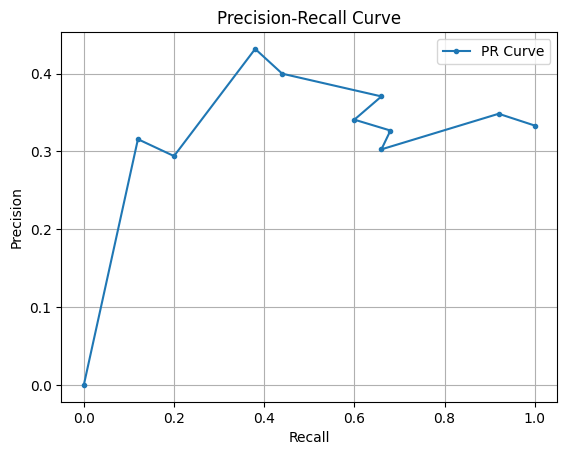

In [69]:
# Plot PRC (Precision-Recall Curve)
plt.plot(recalls, precision, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

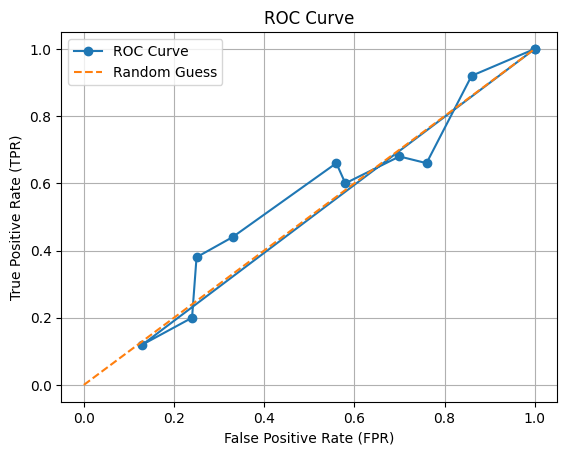

In [70]:
# Plot RoC Curve
plt.plot(fprs, tprs, marker='o', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()
plt.show()

In [71]:
# Report AUPRC and AUROC
avg_auprc = np.mean(auprc_list)
avg_auroc = np.mean(auc_list)

print(f"AUPRC: {avg_auprc}")
print(f"AUROC: {avg_auroc}")

AUPRC: 0.5411324755747037
AUROC: 0.5113636363636364


## Task 3

In [72]:
# generalise plotting as a function
def plot_decision_boundary(cls, dist, p_val, title, xx, yy):
    fig, axes = plt.subplots(1, len(p_values), figsize=(16, 4))
    cmap_light = plt.cm.coolwarm
    
    for idx, p in enumerate(p_val):
        cls = SporadicClassifier(method=dist, p=p)
        
        Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axes[idx].contourf(xx, yy, Z, cmap=cmap_light)
        axes[idx].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, cmap=plt.cm.coolwarm)
        axes[idx].set_title(f"{dist.capitalize()}: p={p}")
        axes[idx].set_xlabel('Petal length')
        axes[idx].set_ylabel('Petal width')
    
    plt.suptitle(title, fontsize=16)
    plt.show()

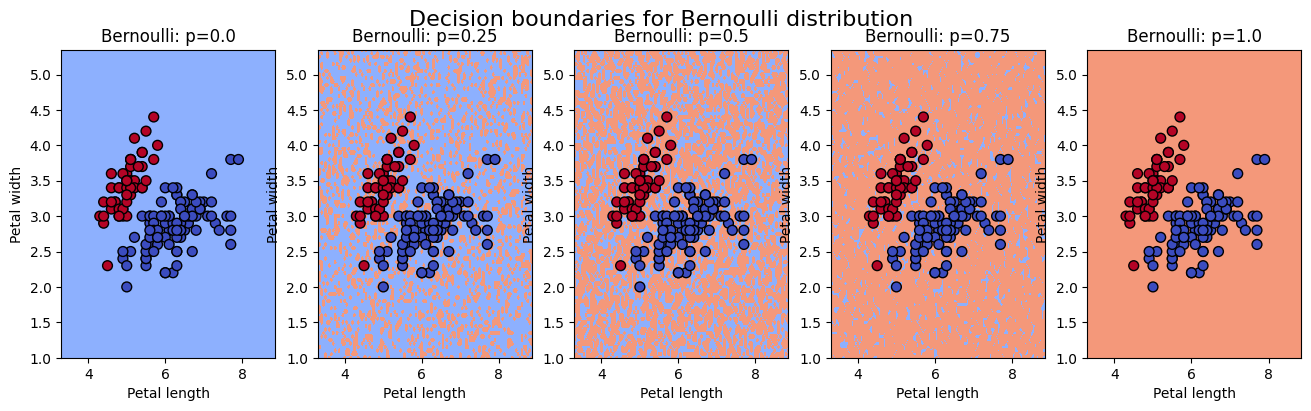

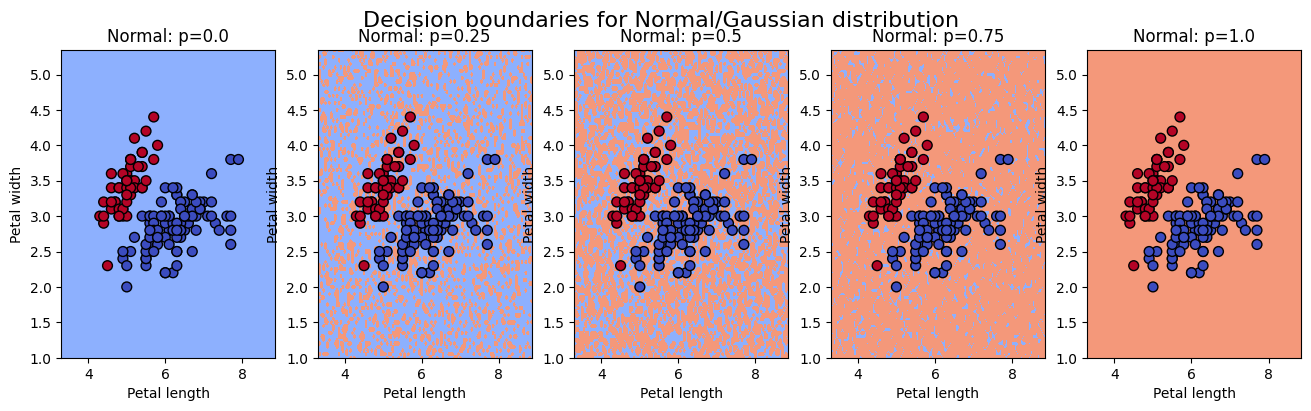

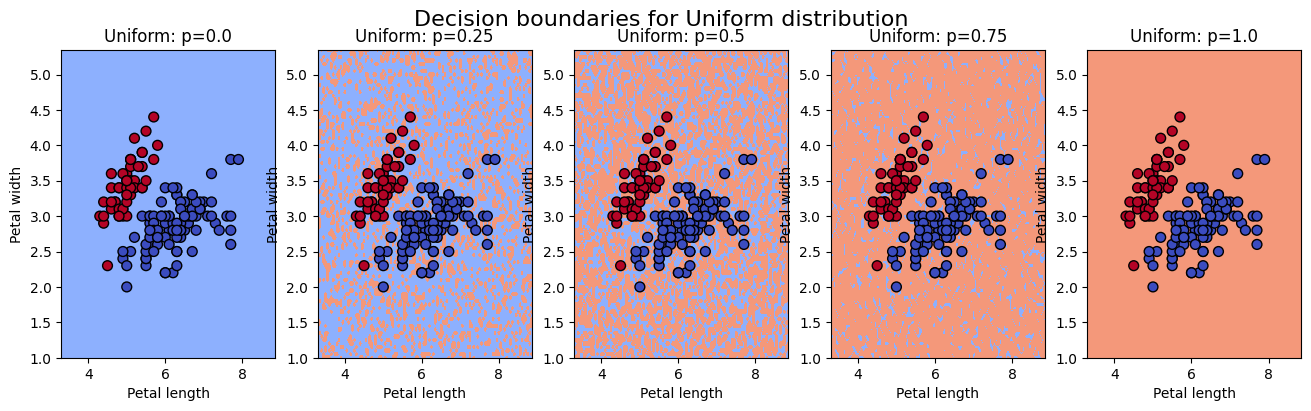

In [73]:
# define ranges for axes
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
p_values = np.arange(0, 1.1, 0.25)

plot_decision_boundary(SporadicClassifier, 'bernoulli', p_values, "Decision boundaries for Bernoulli distribution", xx, yy)
plot_decision_boundary(SporadicClassifier, 'normal', p_values, "Decision boundaries for Normal/Gaussian distribution", xx, yy)
plot_decision_boundary(SporadicClassifier, 'uniform', p_values, "Decision boundaries for Uniform distribution", xx, yy)